# Frequency Analysis
This examples shows how to perform a Modified Fourier Transform (MFT), or a Frequency Modified Fourier Transform (FMFT) on timeseries data using REBOUND. This can be used to determine the fundamental or secular frequencies of planetary systems. The (Frequency) Modified Fourier Transform is much more accurate in determining the frequencies than a simple Fourier Transform. For more information on these methods see: [Laskar (1988)](https://ui.adsabs.harvard.edu/abs/1988A%26A...198..341L/abstract), [Laskar (1990)](https://ui.adsabs.harvard.edu/abs/1990Icar...88..266L/abstract), and [Sidlichovsky and Nesvorny (1996)](https://ui.adsabs.harvard.edu/abs/1996CeMDA..65..137S/abstract).

In this example, we will determine the secular frequencies present in the outer Solar System. Throughout the example, we work in units where $G=1$ and one year is equivalent to $2\pi$ code units.

In [1]:
import rebound
import numpy as np
sim = rebound.Simulation()
rebound.data.add_outer_solar_system(sim)
sim.integrator = "whfast"
sim.dt = sim.particles[1].P/30.13 # About 30 steps per Jupiter orbit

We now integrate forward in time, taking snapshots every 120000 days using the Simulationarchive.

In [2]:
step = int(120000.0/365.25*np.pi*2/sim.dt)
sim.save_to_file("output.bin",step=step,delete_file=True)
Nsamples = 2**13 # Needs to be a power of 2
sim.integrate(step*sim.dt*(Nsamples-1),exact_finish_time=False)

We now have a Simulationarchive with $2^{13}$ snaphots.

In [3]:
sa = rebound.Simulationarchive("output.bin")
print(sa)

<rebound.simulationarchive.Simulationarchive object at 0x7caa18d622d0, nblobs=8192, reb_version=4.4.11>


We next extract the eccentricity e and the periastron $\bar \omega$ of Jupiter from this archive.

In [4]:
inp = np.zeros(Nsamples*2)
for i, sim in enumerate(sa):
    o = sim.particles[1].orbit()
    inp[i*2+0] = o.e*np.cos(o.pomega)
    inp[i*2+1] = o.e*np.sin(o.pomega)

Let's quickly plot this dataset.

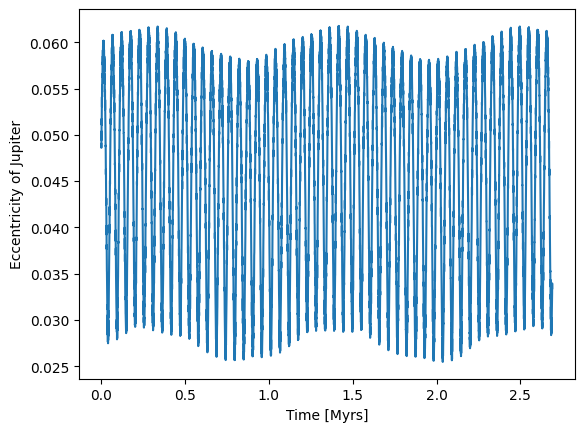

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_xlabel("Time [Myrs]")
ax.set_ylabel("Eccentricity of Jupiter")
ax.plot(np.arange(Nsamples)*step*sim.dt/np.pi/2.0/1e6,np.sqrt(inp[::2]**2+inp[1::2]**2));

Next, we perform the Frequency Modified Fourier Transform algorithm on this time series to extract the secular frequencies, amplitudes, and phases. We specify a minimum and maximum frequency to ensure the FMFT only returns modes in this range. Here, we choose the range of -60"/year to +60"/year.

In [7]:
minfreq = 60.0/1296000.0*step*sim.dt
freq, amp, phase = rebound.frequency_analysis(inp, type=1, minfreq=-minfreq, maxfreq=minfreq)

We can now print out the 10 most dominant frequencies in the signal. Also shown are the amplitudes and the phases.

In [8]:
nfreq = len(freq)
for i in range(nfreq):
    print("nu = %5.2f\"/yr   A = %.7f   phi = %5.1f°" % (freq[i]*1296000.0/step/sim.dt, amp[i], phase[i]/np.pi*180.0))

nu =  4.24"/yr   A = 0.0441150   phi =  30.0°
nu = 28.24"/yr   A = 0.0156774   phi = 306.1°
nu =  3.09"/yr   A = 0.0018430   phi = 119.5°
nu = 52.25"/yr   A = 0.0005711   phi =  42.2°
nu = 29.29"/yr   A = 0.0002578   phi = 253.3°
nu = 27.18"/yr   A = 0.0002552   phi = 183.9°
nu =  5.35"/yr   A = 0.0000729   phi = 135.4°
nu = 53.36"/yr   A = 0.0000541   phi = 325.2°
nu =  4.17"/yr   A = 0.0000483   phi =  75.7°
nu = 51.18"/yr   A = 0.0000191   phi = 282.4°


We can also use these few dominant modes to create a very accurate approximation of the input data. Note that we don't need to worry about converting units in the following code.

In [10]:
approx = np.zeros(Nsamples*2)
for i in range(nfreq):
    approx[0::2] += amp[i]*np.cos(freq[i]*np.arange(Nsamples)+phase[i])
    approx[1::2] += amp[i]*np.sin(freq[i]*np.arange(Nsamples)+phase[i])

The following plot shows the original signal (blue) and the reconstructed signal consiting of 10 modes (orange). They are a very good match.

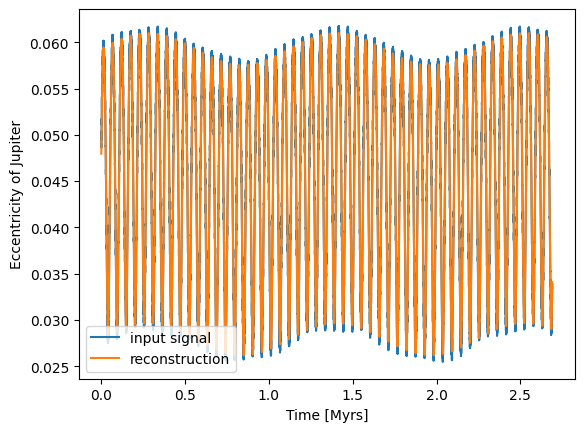

In [11]:
fig, ax = plt.subplots()
ax.set_xlabel("Time [Myrs]")
ax.set_ylabel("Eccentricity of Jupiter")
ax.plot(np.arange(Nsamples)*step*sim.dt/np.pi/2.0/1e6,np.sqrt(inp[::2]**2+inp[1::2]**2), label="input signal")
ax.plot(np.arange(Nsamples)*step*sim.dt/np.pi/2.0/1e6,np.sqrt(approx[::2]**2+approx[1::2]**2),label="reconstruction")
ax.legend();